<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body>
    <div style="text-align:center; border:solid; padding:15px"> <h1><strong>Rapport ParcourSup 2022/2023</strong></h1> </div>

<h2 style="padding-top:40px"><strong>Introduction :</strong></h2>
    <p> 
Dans le cadre de notre SAE en tant qu'étudiants en BUT Passerelle, nous entreprenons une analyse approfondie des données recueillies sur la plateforme Parcoursup concernant les inscriptions à la formation en Informatique. </p>

<div style="padding-top:40px; padding-bottom:40px">
    <h2> <strong>Sommaire :</strong></h2>
    <ol>
        <li><a href="#Fonctions"><strong>Fonctions</strong></a></li>
        <ul>
            <li><a href=#Fonction_principale>Fonction principale</a></li>
            <li><a href=#Fonctions_secondaires>Fonctions secondaires</a></li>
            <li><a href=#Type_graph>Type de graph</a></li>
        </ul>
        <li><a href="#Données"><strong>Données</strong></a></li>
        <ul>
            <li><a href=#Globale>Statistique Globale</a></li>
            <li><a href=#terminale>Statistique étude terminale</a></li>
            <li><a href=#supérieur>Statistique étude supérieur</a></li>
        </ul>
        <li><a href="#Classement"><strong>Classement</strong></a></li>
        <ul>
            <li><a href=#Récup_données>Récupération des données</a></li>
            <li><a href=#Score>Calcul des scores</a></li>
            <li><a href=#Attribution>Attribution du classement</a></li>
            <li><a href=#Affichage>Affichage du classement</a></li>
        </ul>
        <li><a href="#Analyse_classement"><strong>Analyse du classement</strong></a></li>
        <ul>
            <li><a href=#></a></li>
        </ul>
    </ol>
</div>

In [ ]:
!pip install pandas --upgrade
!pip install matplotlib --upgrade
!pip install openpyxl --upgrade
!pip install pyarrow --upgrade

In [2]:
import pandas as pd
from math import *
from matplotlib.pyplot import *
from matplotlib import *

In [68]:
df = pd.read_excel("INFO_Anonyme.xlsx")
categories_a_drop_car_vides = [col for col in df if df[col].isna().all()]
df = df.drop(columns = categories_a_drop_car_vides)

<div id="Fonctions", style="padding-top:40px">
    <h2><strong>Fonctions</strong></h2>
    <ul>
        <li><a href=#Fonction_principale>Fonction principale</a></li>
        <li><a href=#Fonctions_secondaires>Fonctions secondaires</a></li>
        <li><a href=#Type_graph>Type de graph</a></li>
    </ul>
    <p>Dans le but de faciliter notre travail, nous avons tout d'abord créé des fonctions pour récupérer les données des candidats. Nous allons maintenant vous présenter ces différentes fonctions qui nous permettront d'analyser les données des candidats.</p>
</div>

<div id="Fonction_principale", style="padding-top:30px">
    <h3><strong>Fonction principale</strong></h3>
    <p>
        Notre fonction principale est la fonction <code>graph</code> qui nous permet de récupérer les données des candidats et de les afficher sous forme de graphique. <br>
        Elle possède plusieurs paramètres qui nous permet d'afficher divers graphiques selon certaines conditions :
    </p>
    <ul>
        <li>catégorie : Choix de la catégorie que l'on souhaite récupérer les données.</li>
        <li>en_fonction_de : Filtre la DataFrame afin de pouvoir récupérer les données de la catégorie que l'on souhaite.</li>
        <li>type_graph : Permet de choisir le type de graph que l'on souhaite affiché.</li>
        <li>minimum : Les valeurs inférieurs à "minimum" seront stockés dans une catégorie "Autres".</li>
        <li>classement : Filtre la DataFrame afin de récuperer les candidats que l'on souhaite analysés les données.</li>
    </ul>
    
</div>

In [4]:
# Fonction qui permet d'afficher un graphe d'une catégorie avec conditions
# catégorie : à prendre sur excel
# minimum : affiche tout les clés qui ont + que le minimum d'étudiant, et affiche ce qui ont - du minimum dans une catégorie "autres"
# Exemple d'utilisation :
# if(graph("Langue vivante B scolarité - Libellé 2022/2023")):show()
def graph(categorie, en_fonction_de = None, type_graph = 'bar', minimum = 20, classement = None, df = df):

    # Si la catégorie est des Notes, faire un graphique de densité plutôt
    if (categorie[:7] == 'Moyenne'): type_graph = 'densite'

    if en_fonction_de != None:
        if len(en_fonction_de) >= 3:
            for i in range (len(en_fonction_de)-1, 1, -1):
                # On aurait aussi pu faire de la récursivité jusqu'à ce qu'il n'y ait plus qu'une seule dimension à afficher dans le graphique
                graph(categorie = categorie, type_graph = type_graph, minimum = minimum,
                      classement = classement, df = df, en_fonction_de = [en_fonction_de[0], en_fonction_de[i]])
                show()
                en_fonction_de.pop(i)
        if len(en_fonction_de) == 2:
            df = df.loc[df[en_fonction_de[0]] == en_fonction_de[1]]
            print("\n" + en_fonction_de[0] + " : " + en_fonction_de[1] + "\n")
        else: return False

    if classement != None:
        # On filtre afin d'observer les étudiants dans le "classement"
        df = df.loc[df["ID"].isin(classement)]
        
    if (type_graph == 'densite'): graph_densite(categorie, df)

    # Convertir toutes les valeurs en chaînes pour uniformiser
    str_values = df[categorie].astype(str)
    dic = str_values.value_counts()
    X_labels = dic.index.tolist()
    Y = dic.values

    # Appelle la fonction departement si la catégorie commence par "Commune"
    if categorie[:7] == "Commune":
        dep = departement(df)
        X_labels = list(dep.keys())
        Y = list(dep.values())

    # Mise à jour de X et Y avec les fonctions autres_X et autres_Y
    X_labels = autres_X(X_labels, Y, minimum)
    Y = autres_Y(Y, minimum)
        
    # Supprimer les nan si c'est la valeur la plus haute
    if (X_labels[0] == 'nan'): 
        X_labels = X_labels[1:]
        Y = Y[1:]
 
    # Remplacer certains labels par d'autres étiquettes
    X_labels = a_remplacer(X_labels)
        
    if (type_graph == 'bar'): return graph_bar(categorie, minimum, Y, X_labels, dic)
    if (type_graph == 'circulaire'): return graph_circulaire(Y, X_labels, dic, categorie)

<div id="Fonctions_secondaires" style="padding-top:40px">
    <h3>Fonctions secondaires</h3>
    <p>Nous disposons de cinq fonctions secondaires qui assurent le bon fonctionnement de notre fonction principale :</p>
    <ul>
        <li>La fonction <code>a_remplacer</code> permet de changer le nom d'un label par un autre</li>
        <li>Les fonctions <code>autres_X</code> et <code>autres_Y</code> permettent de regrouper les données inférieures à "minimum" dans une catégorie appeAée "autres"</li>
        <li>La fonction <code>departement</code> récupère toutes les communes afin de les regrouper par département</li>
        <li>La fonction <code>classement</code> récupère les positions des candidats dans le classement (sera introduite plus tard, lorsque nous aurons le classement)</li>
    </ul>
</div>


<p style="padding-top:30px">La fonction <code>a_remplacer</code> remplace les noms de labels par des étiquettes qui leurs sont associés.</p>

In [103]:
# Fonction qui remplace les noms d'un label par un autre nom si besoin
def a_remplacer(X_labels):
    labels_remplacer = {"nan" : "Non renseigné", "Sciences et Technologies de l'Industrie et du Développement Durable" : "STI2D", 
                        "Sciences et Technologies du Management et de la Gestion" : "STMG", 
                        "Education Physique et Sportive (facultatif)" : "Education Physique et Sportive",
                        "Droits et Grands Enjeux du monde Contemporain facultatif" : "Droits et Grands Enjeux du monde Contemporain"}

    for i in range(len(X_labels)):
        if X_labels[i] in labels_remplacer.keys():
            X_labels[i] = labels_remplacer[X_labels[i]]

    return X_labels

<p style="padding-top:30px">La fonction <code>autres_X</code> regroupe les labels dont le nombre de candidats inférieur à "minimum" dans une catégorie appelée "Autres". Pour cela, la fonction vérifie si le nombre d'étudiant dans un label est supérieur au minimum.</p>

In [6]:
# Fonction qui renvoie une liste avec +n étudiant et le reste dans 'autres' pour X
def autres_X(X, Y, minimum):
    tab = []
    autre_inclus = False
    for i in range(len(X)):
        if (Y[i] >= minimum): tab.append(X[i])
        else: autre_inclus = True
    if autre_inclus: tab.append('Autres')
    return tab

<p style="padding-top:30px">La fonction <code>autres_Y</code> vérifie le nombre de candidat dans chaque label afin de regrouper le nombre de candidat dans la catégorie "Autres" lorsque celui-ci est inférieur à "minimum."</p>

In [7]:
# Fonction qui renvoie une liste avec +n étudiant et le reste dans 'autres' pour Y
def autres_Y(Y, minimum):
    tab = []
    autre = 0
    for valeur in Y:
        if (valeur >= minimum): tab.append(valeur)
        else: autre += valeur
    if (autre > 0): tab.append(autre)
    return tab

<p style="padding-top:30px">La fonction <code>departement</code> récupère les communes de tous les candidats afin de les regrouper par département. Pour ce faire, la fonction extrait les deux premiers chiffres de chaque code postal d'étudiant et les ajoute à un tableau s'ils ne sont pas déjà présents. Ensuite, elle calcule le nombre d'étudiants dans chaque département.</p>

In [9]:
# Fonction qui renvoie un dictionnaire contenant les différents départements ainsi que le nombre de candidat dans chacune des départements
def departement(df):
    dic_dep = {}
    dic_dep_trier = {}

    # Récupère les différents départements présents dans le libéllé
    for i in df["Commune Etablissement origine - CodePostal 2022/2023"]:
        if ((type(i) != str) and (len(str(i)) == 5)):
           if str(i)[:2] not in dic_dep.keys():
               dic_dep[str(i)[:2]] = 0

    # Calcul le nombre de candidat dans chaque département
    for i in dic_dep.keys() :
        cpt = 0
        for j in df["Commune Etablissement origine - CodePostal 2021/2022"]:
            if (str(i) == str(j)[:2]): cpt += 1
        dic_dep[i] = cpt

    # Trie dans l'ordre décroissant les nombres de candidats dans chaque département
    nb_dep = sorted(dic_dep.values(), reverse=True)
    
    for i in nb_dep:
        for j in dic_dep:
            if(dic_dep[j] == i): dic_dep_trier[j] = i

    return dic_dep_trier

<div id="Type_graph" style="padding-top:40px">
    <h3>Type de graph</h3>
    <p>Nous disposons de trois différentes fonctions de graphique qui nous permettront d'analyser les données des candidats :</p>
    <ul>
        <li>La fonction <code>graph_bar</code> nous permet d'analyser la quantité, le ratio et la fréquence d'une catégorie de données</li>
        <li>La fonction <code>graph_circulaire</code> nous permet de comparer des données</li>
        <li>La fonction <code>graph_dentite</code> nous permet d'analyser la distribution des moyennes des candidats</li>
    </ul>
</div>


<p style="padding-top:30px">La fonction <code>graph_bar</code> nous permet d'afficher un graphique en bâton</p>

In [10]:
# Fonction qui affiche spécifiquement un graphique en bâtons à partir de graph()
def graph_bar(categorie, minimum, Y, X_labels, dic):
    # Si la catégorie est "Autres" est 2 fois supérieux que la plus grande barre, alors on n'affiche pas la catégorie "Autres" 
    if(("Autres" in X_labels) and (Y[0]*2 < Y[-1])): Y[-1] = Y[0]
        
    # Afficher la série sans la dernière ligne d'information
    print(dic.to_string(max_rows = 10))
        
    # Ajuster la taille du graphique en fonction du nombre de barres (1 à 2 fois la largeur standard)
    if len(X_labels) >= 20:
        largeur = min(6.4 * (1 + (len(X_labels) - 20) / 10), 12.8)
        figure(figsize = (largeur, 4.8))
    
    X = range(len(X_labels)) # Utiliser range(len(X_labels)) pour l'axe des X
    gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # Ajuster les graduations de l'axe Y pour n'avoir que des nombres entiers

    # Mets des jolies couleurs et Autre en noir
    nbr_couleurs = len(Y) - 1 if 'Autres' in X_labels else len(Y)
    cmap = colormaps['hsv'].resampled(nbr_couleurs)
    colors = [cmap(i) for i in range(nbr_couleurs)]
    if ('Autres' in X_labels): colors.append('black')    

    rot = -45
    if(len(X_labels) > 20): rot = 90
    
    bar(X, Y, color = colors)
    ylabel(categorie.replace('Libellé en', 'Libellé en\n'))
    xticks(ticks = X, labels = X_labels, rotation = rot, ha = 'left')
    return True

In [ ]:
if (graph("Sexe")): show()

<p style="padding-top:30px">On peut également afficher des graphiques "en camembert" avec <code>graph_circulaire</code>.</p>

In [11]:
def graph_circulaire(Y, X_labels, dic, categorie):    
    print(dic.to_string(max_rows = 10))
    fig, ax = subplots()
    ax.pie(Y, labels = X_labels, autopct = '%1.1f%%')
    ylabel(categorie.replace('Libellé en', 'Libellé en\n'), labelpad = 200)
    return True

In [ ]:
if graph("Sexe", type_graph='circulaire'): show()

<p style="padding-top:30px">Le dernier type de graphiques que nous avons est un histogramme de densité. La fonction <code>graph_densité</code> affiche un histogramme avec un nombre arbitraire de barres, et affiche la moyenne des valeurs. Elle permet notamment d'afficher des notes et de comparer les notes entre 2 groupes si on l'appelle 2 fois avec des groupes différents.</p>

In [12]:
# Histogramme de densité, utile notamment pour les notes qui sont des float entre 0 et 20
def graph_densite(categorie, df):
    notes = pd.to_numeric(df[categorie], errors = 'coerce').dropna()
    hist(notes, bins = 40, density = True, alpha = 0.6, color = 'g')
    moyenne = notes.mean()
    axvline(moyenne, color = 'blue', linestyle = 'dashed', linewidth = 1)
    text(moyenne, ylim()[1], f'Moyenne: {moyenne:.2f}', ha = 'right', va = 'top', color = 'blue')
    title(f"Densité de {categorie}")
    ylabel("Densité")
    xlabel("Valeurs")
    return True

In [ ]:
graph('Moyenne du Candidat en Enseignement scientifique pour trimestre 1')

<div id="Données", style="padding-top:40px">
    <h2><strong>Données</strong></h2>
    <ul>
        <li><a href=#Globale>Statistique Globale</a></li>
        <li><a href=#terminale>Statistique étude terminale</a></li>
        <li><a href=#supérieur>Statistique étude supérieur</a></li>
    </ul>
    <p>Présentation de nos données</p>
</div>


<div id="Globale", style="padding-top:30px">
    <h3>Statistique Globale</h3>
    <p>Nous allons dans un premier temps présenter les données globales que l'ont possède sur les candidatures</p>
</div>

<h4 style="backgroud-color: black;"><li>Répartition des vœux</li></h4>

Vœu confirmé - Libellé
Validée        3779
Non validée     365


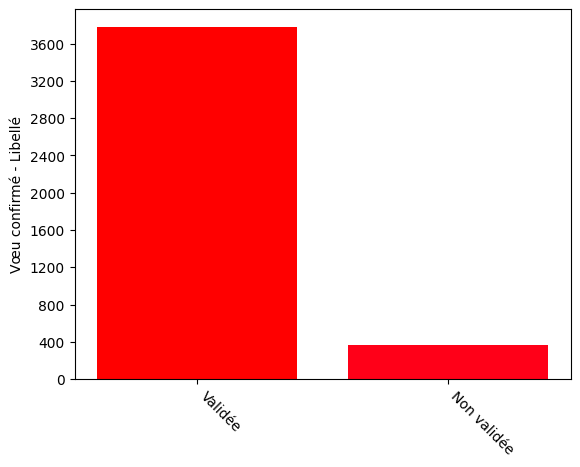

In [13]:
if graph("Vœu confirmé - Libellé"): show()

<h4 style="padding-top:30px"> <li> Répartition des Sexes </li> </h4>

Sexe
Masculin    3533
Féminin      611


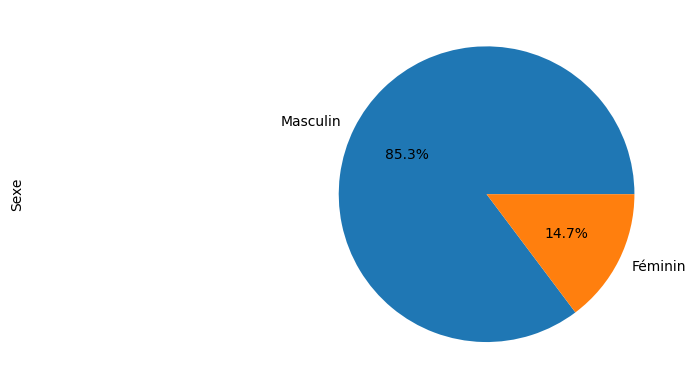

In [14]:
if (graph("Sexe", type_graph = "circulaire")): show()

<h4 style="padding-top:30px"> <li> Répartition des types de formation </li> </h4>

Type Formation - Libellé  2022/2023
Terminale                                             3022
Licence                                                321
nan                                                    239
BUT                                                    145
Formations des écoles d'ingénieurs                     110
                                                      ... 
Mentions complémentaires                                 3
Licence professionnelle                                  2
DEUST                                                    2
Formations d'art, de design et du spectacle vivant       2
Etudes de santé                                          2


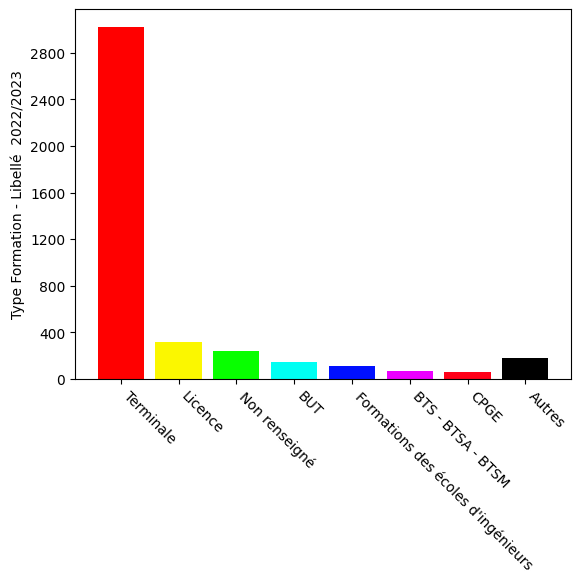

In [15]:
if (graph("Type Formation - Libellé  2022/2023", minimum=50)): show()

<h4 style="padding-top:30px"> <li> Répartition des départements</li> </h4>

Commune Etablissement origine - CodePostal 2022/2023
nan      345
93200    182
93430    155
93600    103
95100     98
        ... 
64100      1
60488      1
49001      1
22015      1
93210      1


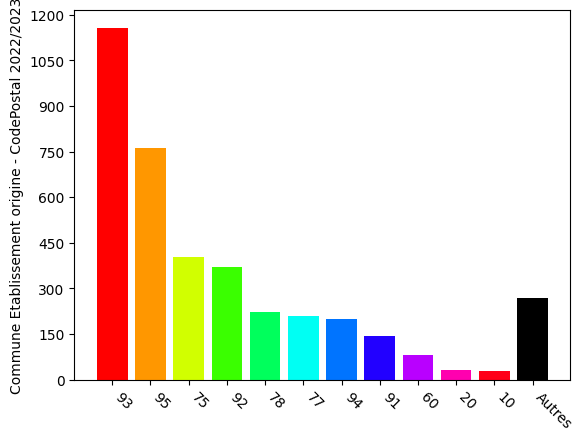

In [16]:
if (graph("Commune Etablissement origine - CodePostal 2022/2023")): show()

<div id="terminale", style="padding-top:30px">
    <h3>Statistique étude terminale</h3>
    <p>Dans cette partie, nous nous pencherons sur l'analyse des données des candidats issus de la formation terminale pour l'année 2022/2023</p>
</div>

In [17]:
terminale = df.loc[df["Type Formation - Libellé  2022/2023"] == "Terminale"]

<h4 style="padding-top:30px"><il>Répartition des sexes</il></h4>

Sexe
Masculin    2623
Féminin      399


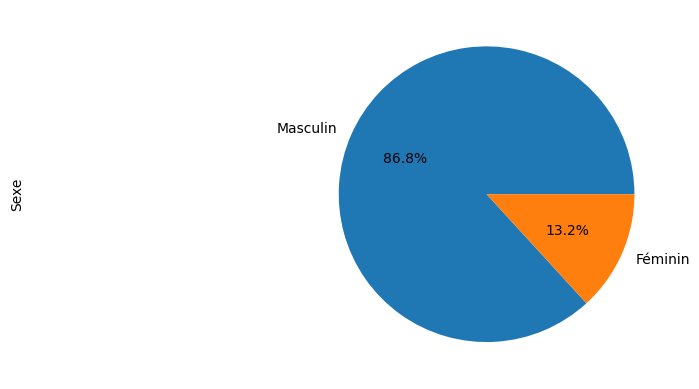

In [122]:
if (graph("Sexe", type_graph = "circulaire", df=terminale)): show()

<h4 style="padding-top:30px"><il>Répartition de la bourse</il></h4>

<p>On observe que les femmes ont un pourcentage de boursier légérement supérieur que ceux des hommes</p>


Sexe : Masculin

Candidat boursier - Libellé
Non boursier                           1709
Boursier de l'enseignement scolaire     914


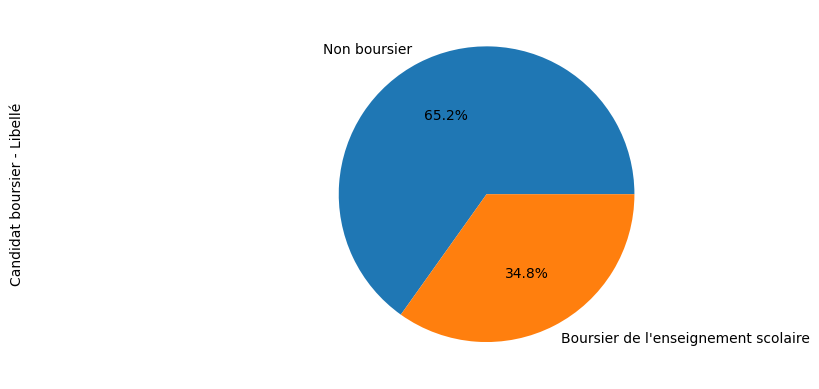


Sexe : Féminin

Candidat boursier - Libellé
Non boursier                           222
Boursier de l'enseignement scolaire    177


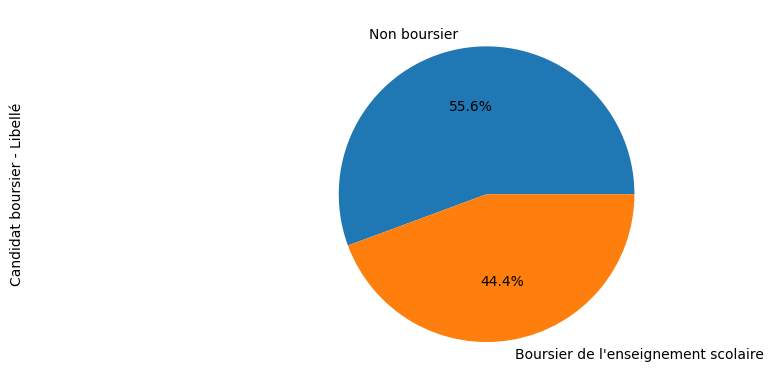

In [20]:
if (graph("Candidat boursier - Libellé", ["Sexe", "Féminin", "Masculin"], type_graph = "circulaire", df=terminale)): show()

<h4 style="padding-top:30px"><li>Répartition des série de classe</li></h4>

Série de classe - Libellé 2022/2023
Série Générale                                                         1951
Sciences et Technologies de l'Industrie et du Développement Durable     743
Sciences et Technologies du Management et de la Gestion                 222
Professionnelle                                                          66
Scientifique                                                             11
                                                                       ... 
Technologique                                                             2
Préparation au Bac Européen                                               1
Brevet des Métiers d'Arts                                                 1
Littéraire                                                                1
Baccalauréat International                                                1


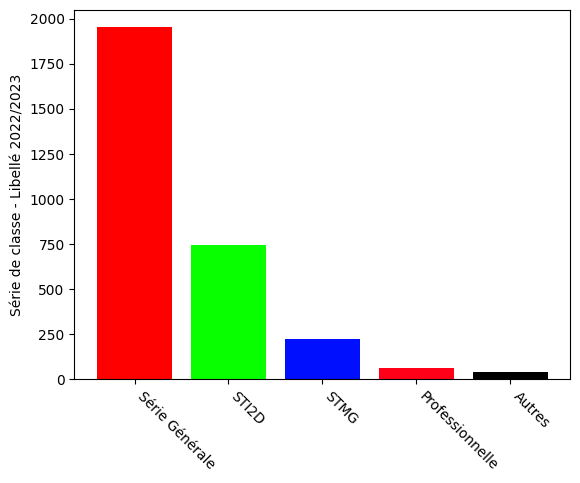

In [21]:
if (graph("Série de classe - Libellé 2022/2023", df = terminale)): show()

<h4 style="padding-top:30px"><li>Répartition des options facultatives et des spécialités</li></h4>

Option facultative 1 Scolarité - Libellé 2022/2023
nan                                                         2303
Mathématiques Expertes                                       437
Mathématiques Complémentaires                                114
Education Physique et Sportive (facultatif)                   61
Langues et cultures de l'antiquité : Latin                    27
                                                            ... 
Droits et Grands Enjeux du monde Contemporain facultatif      10
Histoire des arts                                              7
Musique                                                        6
Langues et cultures de l'antiquité : Grec                      4
Danse                                                          1


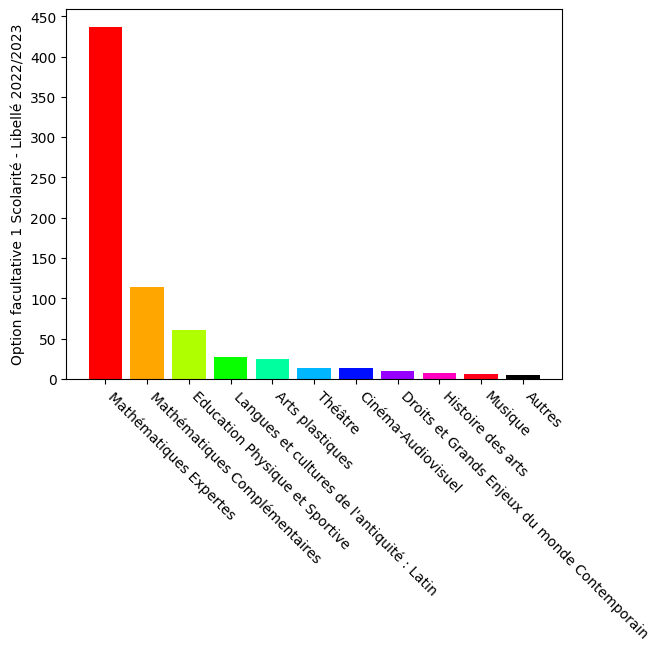

In [113]:
if (graph("Option facultative 1 Scolarité - Libellé 2022/2023", minimum=5 , df = terminale)): show()

Option facultative 2 Scolarité - Libellé 2022/2023
nan                                                         2979
Mathématiques Expertes                                        33
Mathématiques Complémentaires                                  6
Langues et cultures de l'antiquité : Latin                     2
Langues et cultures de l'antiquité : Grec                      1
Droits et Grands Enjeux du monde Contemporain facultatif       1


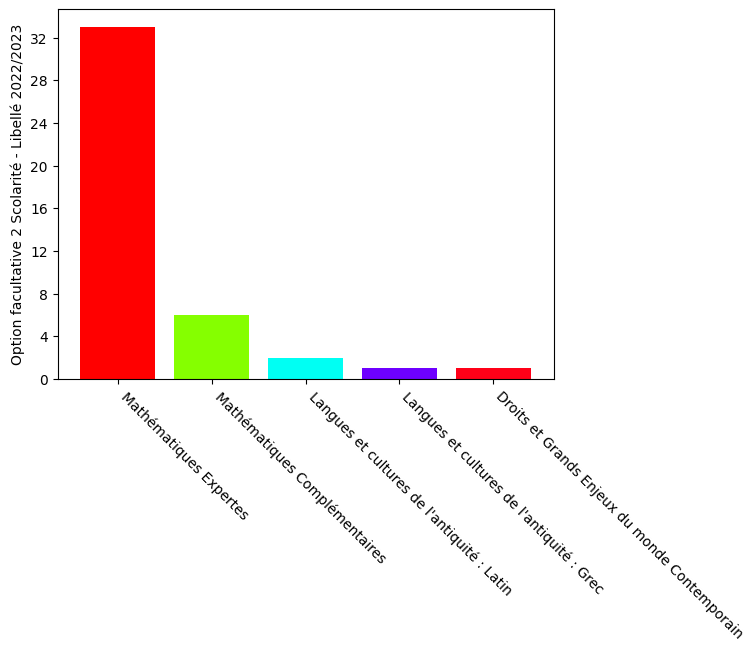

In [112]:
if (graph("Option facultative 2 Scolarité - Libellé 2022/2023", minimum=0 , df = terminale)): show()

Spécialité / Mention - Libellé  2022/2023
nan                                                                            1986
Système informatique et numérique                                               578
Systèmes d'information et de gestion                                             88
Innovation technologique et eco conception                                       83
Mercatique                                                                       64
                                                                               ... 
Technicien d'étude du bâtiment. option b : assistant en architecture              1
Technicien menuisier agenceur                                                     1
Métiers de la mode option vêtement                                                1
Systèmes numériques, option b: audiovisuels, réseau, équipement domestiques       1
Procédés de la chimie, de l'eau et des papiers-cartons                            1


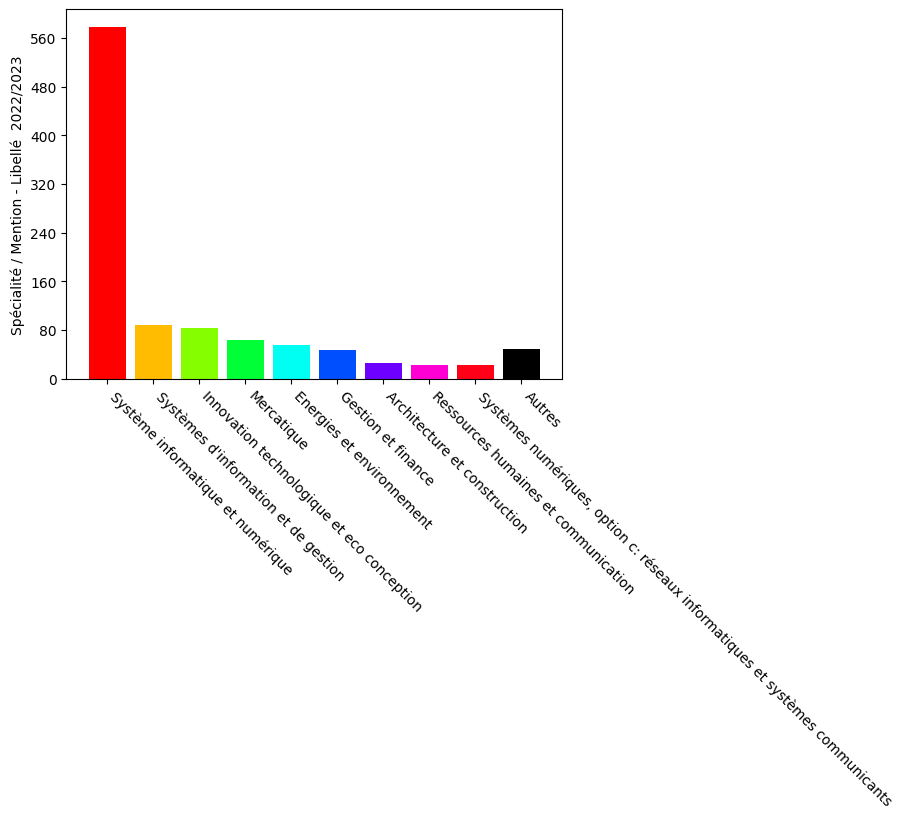

In [125]:
if (graph("Spécialité / Mention - Libellé  2022/2023", df = terminale)): show()

<h4 style="padding-top:30px"><li>Répartition des langues vivantes</li></h4>

Langue vivante A scolarité - Libellé 2022/2023
Anglais      2941
Arabe          27
Espagnol       17
Allemand       15
Français       13
Italien         6
Portugais       1
Russe           1
Tchèque         1


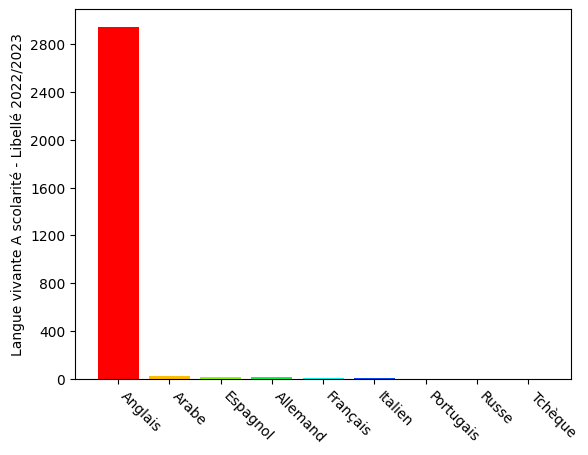

In [24]:
if (graph("Langue vivante A scolarité - Libellé 2022/2023", minimum = 0, df = terminale)): show()

Langue vivante B scolarité - Libellé 2022/2023
Espagnol    2174
Allemand     539
Arabe         83
Anglais       77
nan           53
            ... 
Hébreu         3
Turc           2
Polonais       2
Japonais       1
Coréen         1


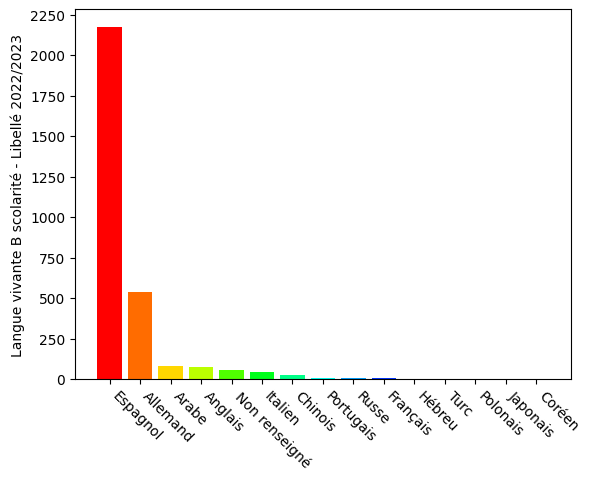

In [25]:
if (graph("Langue vivante B scolarité - Libellé 2022/2023", minimum=0, df = terminale)): show()

<h4 style="padding-top:30px"><li>Répartition des établissements d'origines</li></h4>

Nom Etablissement origine 2022/2023
Lycée Le Corbusier                65
Lycée Jean Jaures                 61
Lycée Simone De Beauvoir          54
Lycée Paul Eluard                 51
LYCEE POLYVALENT GUSTAVE MONOD    50
                                  ..
Lycée CASSINI                      1
Lycée français de Francfort        1
Lycée polyvalent Jean Moulin       1
Lycée Alexis De Tocqueville        1
lycée teboulba                     1


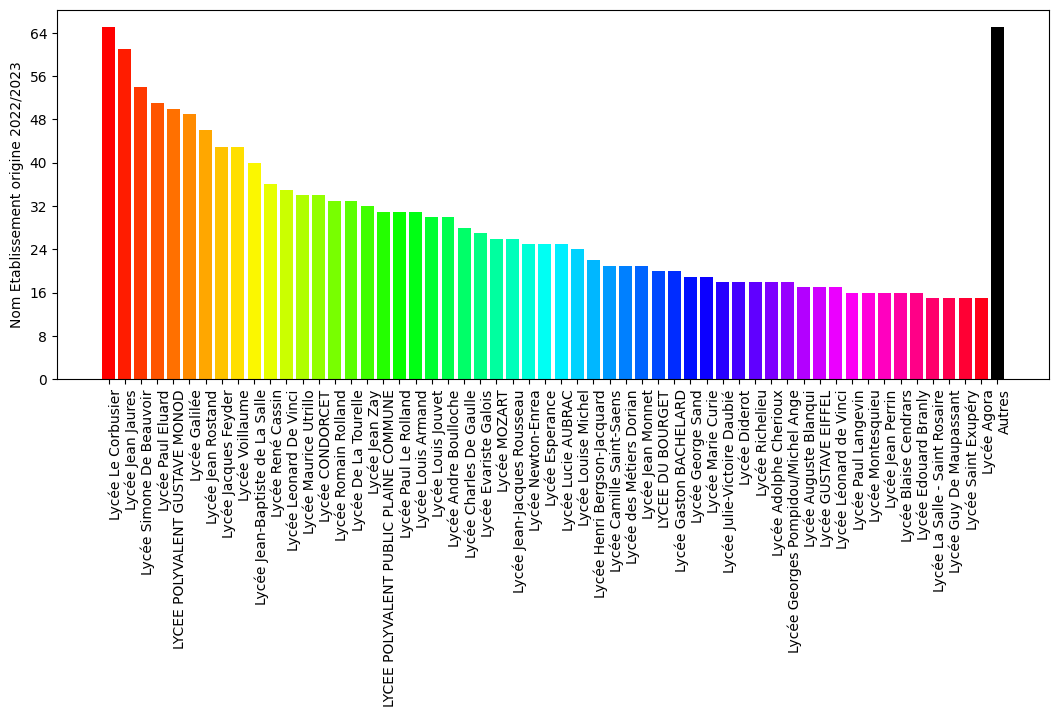

In [22]:
if (graph("Nom Etablissement origine 2022/2023", minimum = 15, df = terminale)): show()

<div id="supérieur", style="padding-top:30px">
    <h3>Statistique étude supérieur</h3>
    <p>Nous allons maintenant nous concentrer sur l'analysee des données des candidats en études supérieures pour l'année 2022/2023.</p>
</div>

In [123]:
superieur = df.loc[df["Type Formation - Libellé  2022/2023"] != "Terminale"] 
superieur = superieur.loc[df["Type Formation - Libellé  2022/2023"] != "Première"]

<h4 style="padding-top:30px"><li>Répartion des sexes</li></h4>

Sexe
Masculin    906
Féminin     210


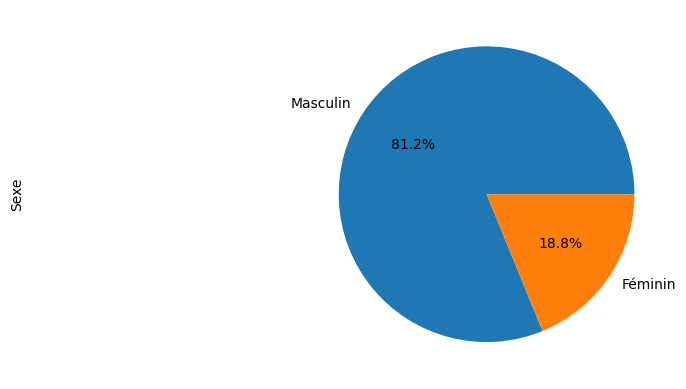

In [120]:
if (graph("Sexe", type_graph = "circulaire", df=superieur)): show()

<h4 style="padding-top:30px"><li>Répartion de la bourse</li></h4>


Sexe : Masculin

Candidat boursier - Libellé
Non boursier                            507
Boursier de l'enseignement supérieur    398
Boursier de l'enseignement scolaire       1


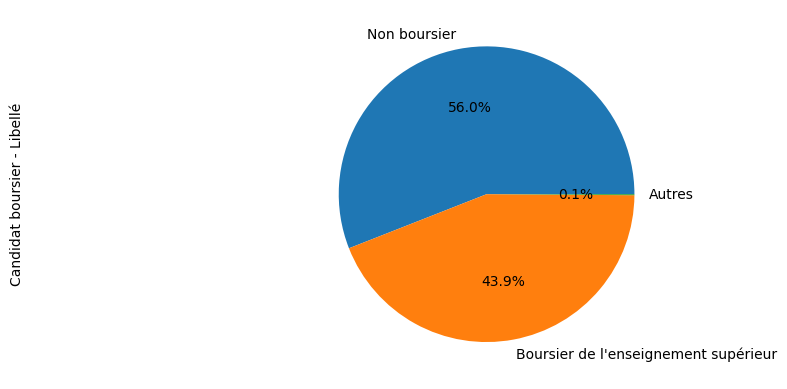


Sexe : Féminin

Candidat boursier - Libellé
Non boursier                            126
Boursier de l'enseignement supérieur     84


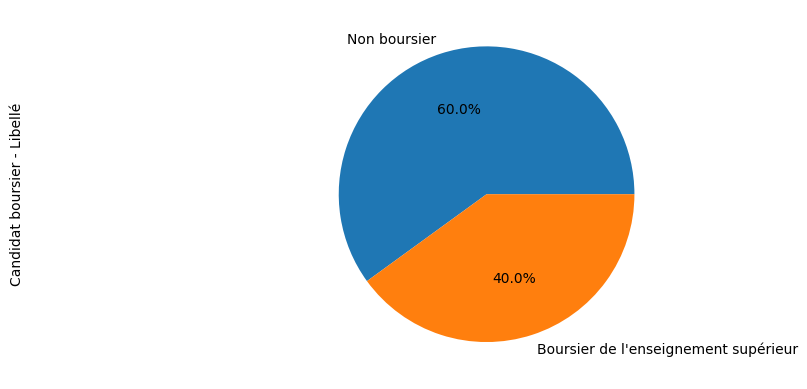

In [114]:
if (graph("Candidat boursier - Libellé", ["Sexe", "Féminin", "Masculin"], type_graph = "circulaire", df=superieur)): show()

<h4 style="padding-top:30px"><li>Répartion des séries de formation et du niveau d'étude</li></h4>

Type Formation - Libellé  2022/2023
Licence                                               321
nan                                                   239
BUT                                                   145
Formations des écoles d'ingénieurs                    110
BTS - BTSA - BTSM                                      69
                                                     ... 
Mentions complémentaires                                3
Licence professionnelle                                 2
DEUST                                                   2
Formations d'art, de design et du spectacle vivant      2
Etudes de santé                                         2


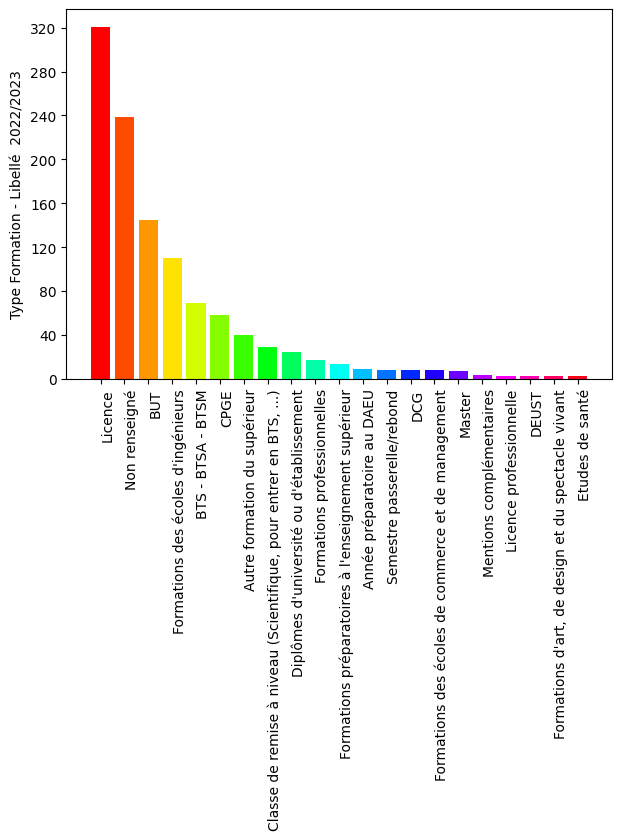

In [72]:
if (graph("Type Formation - Libellé  2022/2023", minimum=0, df = superieur)): show()

 Niveau Etude - Libellé 2022/2023
1ère année d'études supérieures              697
nan                                          238
2nd année d'études supérieures                79
Année préparatoire aux études supérieures     54
Non scolarisé                                 30
3ème année d'études supérieures               11
4ème année d'études supérieures ou plus        7


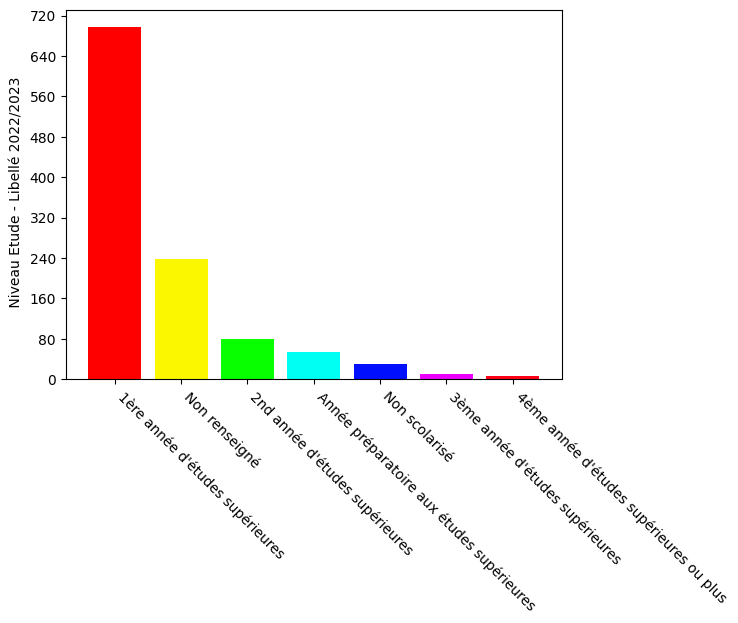

In [66]:
if (graph(" Niveau Etude - Libellé 2022/2023", minimum=0, df = superieur)): show()

<h4 style="padding-top:30px"><li>Répartion des Etablissements d'origines</li></h4>

Nom Etablissement origine 2022/2023
nan                                                             239
Université Sorbonne Paris Nord                                  119
Université Paris Cité                                            35
I.U.T de Villetaneuse - Université Sorbonne Paris Nord           33
Université Paris 8                                               28
                                                               ... 
Talia Académie                                                    1
Isifa                                                             1
Conservatoire National des arts et métiers                        1
Lycée Camille Pissarro                                            1
Ecole IRIS - Institut des Ressources Informatiques Supérieur      1


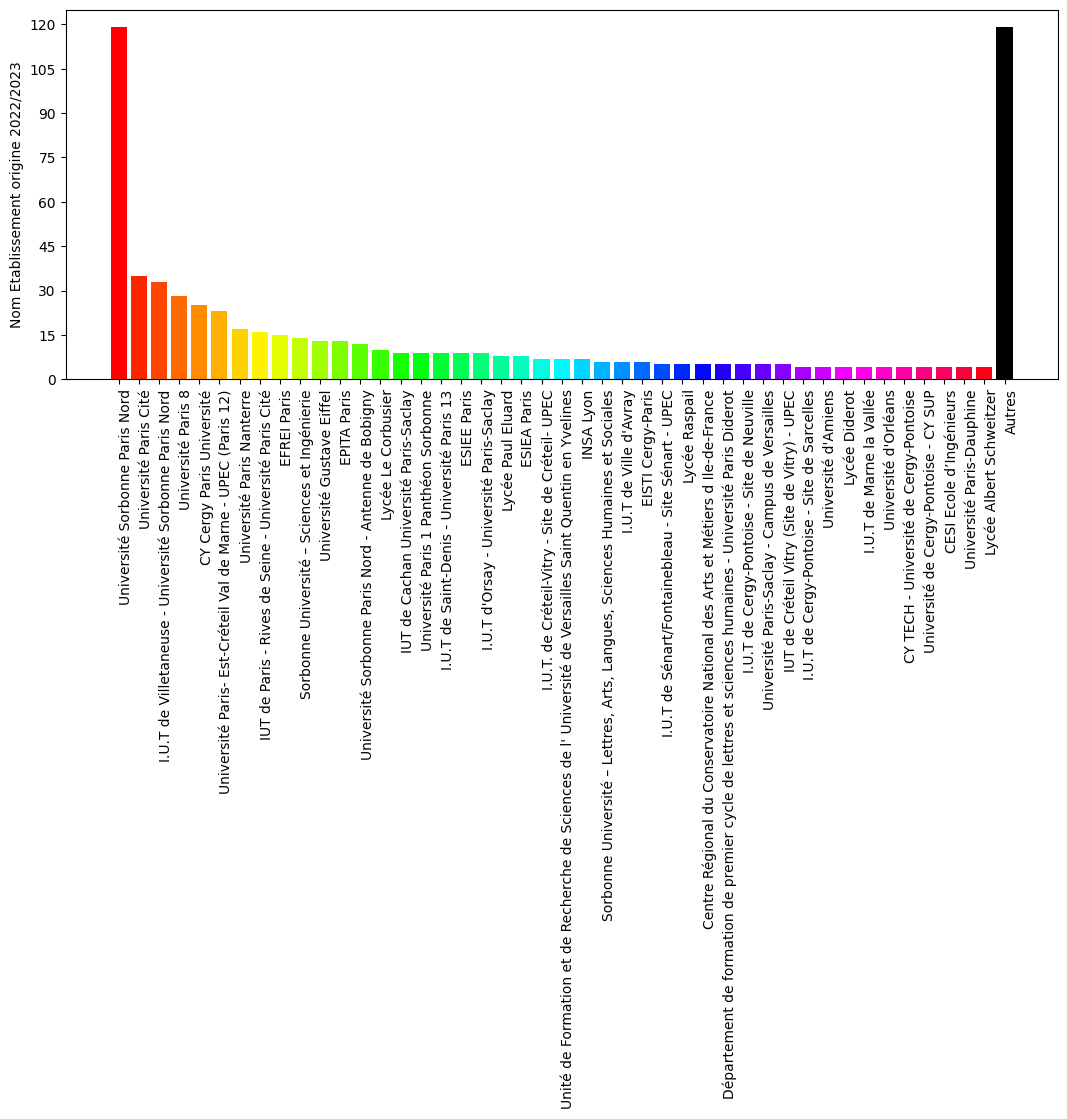

In [31]:
if (graph("Nom Etablissement origine 2022/2023", minimum = 4, df = superieur)): show()

<div id="Classement", style="padding-top:40px">
    <h2><strong>Classement</strong></h2>
    <ul>
        <li><a href=#Récup_données>Récupération des données</a></li>
        <li><a href=#Score>Calcul des scores</a></li>
        <li><a href=#Attribution>Attribution du classement</a></li>
        <li><a href=#Affichage>Affichage du classement</a></li>
    </ul>
    <p>
        Nous allons à nôtre tour proposer un classement à l'aide des données que nous possédons.<br>
        Pour cela, nous allons procéder par plusieurs étapes :
        <ol>
            <li>Récupérer toute les moyennes et notes d'épreuves de chaque candidats</li>
            <li>Classer uniquement les candidats qui nous intéressent, avec un filtre</li>
            <li>Calculer un score pour chaque candidats à l'aide de certaines conditions</li>
            <li>Attribuer un rang à chaque candidat</li>
        </ol>
    </p>
</div>

<div id="Récup_données", style="padding-top:30px">
    <h3>Récupération des données</h3>
    <p>On commence par récupérer les moyennes de chaque candidat à l'aide nos fonction :</p>
    <ul>
        <li>recup_donnee_epreuve</li>
        <li>recup_donnee_trimestre</li>
        <li>recup_donnee_candidat</li>
        <li>moyenne_candidat</li>
    </ul>
</div>

<p> La fonction <code>recup_donnee_epreuve</code> permet de :</p> 
<ul>
    <li>Récupérer les note de chaque épreuve</li>
    <li>Calculer la moyenne des note des épreuves en contrôle continue</li>
</ul>

In [131]:
def recup_donnee_epreuve(df, position):
    # Ajoute les matières des épreuves du candidat
    matiere_epreuve = []
    # Ajoute les moyennes des épreuves du candidat, Pas de note = 0
    moyenne_epreuve = []
    for col in df:
        if col.startswith("Epreuve - Libelle"): 
            if len(matiere_epreuve) != len(moyenne_epreuve):
                moyenne_epreuve.append(0) # Pas de note = 0
            matiere_epreuve.append(df[col][position])
        if col.startswith("Note de l'épreuve"):
            moyenne_epreuve.append(df[col][position])
    
    if len(matiere_epreuve) != len(moyenne_epreuve):
        moyenne_epreuve.append(0) # Pas de note = 0
    
    matiere, moyenne = [], []
    # Regroupe les moyennes des 2 années (premières + terminale)
    for i in range(len(matiere_epreuve)):
        if ("Moyenne" in matiere_epreuve[i]): a = 0
        elif matiere_epreuve[i][-1:] != ')':
            matiere.append(matiere_epreuve[i] + " (Épreuve)")
            moyenne.append(moyenne_epreuve[i])
        elif "Contrôle continu de première" in matiere_epreuve[i]:
            matiere.append(matiere_epreuve[i][:-13] + ")")
            moyenne.append(float(str((moyenne_epreuve[i] + moyenne_epreuve[i+1]) / 2)[:5]))
        elif "épreuve ponctuelle de première" in matiere_epreuve[i]:
            matiere.append(matiere_epreuve[i][:-33] + " (Épreuve)")
            moyenne.append(moyenne_epreuve[i])
                
    return [matiere, moyenne]

<p style="padding-top:30px"> La fonction <code>recup_donnee_trimestre</code> permet de :</p> 
<ul>
    <li>Récupérer les moyennes de chaque trimestre de chaque matière</li>
    <li>Calculer la moyenne des moyennes de chaque trimestre de chaque matière</li>
</ul>

In [133]:
def recup_donnee_trimestre(df, position, cible = "Candidat"):
    matiere_trimestre = []
    for col in df.columns:
        if col.startswith("Matière - Libellé"):
            if col.endswith(".1"):
                matiere = col[21:-19]
            else:
                matiere = col[21:-17]
            matiere_trimestre.append(matiere)
            
    prefix_moyenne = "Moyenne du Candidat" if cible == "Candidat" else "Moyenne classe Candidat"
    moyenne_trimestre = [df[col][position] for col in df.columns if col.startswith(prefix_moyenne)]

    # Trouve toutes les matières de tous les trimestres et fait la somme (première + terminale)
    matiere_moyenne_dict = {}
    for matiere, moyenne in zip(matiere_trimestre, moyenne_trimestre):
        if moyenne not in ["Aucune note", "Dispensé(e)", "En attente"]:
            if matiere + " (Trimestre)" not in matiere_moyenne_dict:
                matiere_moyenne_dict[matiere + " (Trimestre)"] = [moyenne, 1]
            else:
                matiere_moyenne_dict[matiere + " (Trimestre)"][0] += moyenne
                matiere_moyenne_dict[matiere + " (Trimestre)"][1] += 1
    
    # Calculer les moyennes finales par matière
    for matiere, (somme, nb_trimestre) in matiere_moyenne_dict.items():
        if nb_trimestre != 0: matiere_moyenne_dict[matiere] = round(somme / nb_trimestre, 2)
        else: matiere_moyenne_dict[matiere] = "Aucune note"
    
    # Retourne [matiere, moyenne]
    return [list(matiere_moyenne_dict.keys()), list(matiere_moyenne_dict.values())]

<p style="padding-top:30px">La fonction <code>recup_donnee_candidat</code> nous permet de récupérer :</p>
    <ul>
        <li>Les notes d'épreuves d'un candidat à l'aide de la fonction <code>recup_donnee_epreuve</code></li>
        <li>Les moyennes de chaque matière d'un candidat à l'aide de la fonction <code>recup_donnee_trimestre</code></li>
        <li>Supprimer les doublons de chaque matière</li>
    </ul

In [134]:
# Fonction qui renvoie les matières et les notes d'un candidat
def recup_donnee_candidat(df, position):
    matiere, moyenne = recup_donnee_epreuve(df, position)

    # Récupération des données pour les trimestres
    trimestre_data = recup_donnee_trimestre(df, position)
    trimestre_matieres, trimestre_moyennes = trimestre_data

    # Ajout des données des trimestres aux listes matiere et moyenne
    matiere.extend(trimestre_matieres)
    moyenne.extend(trimestre_moyennes)
    
    for x in matiere:
        if "(Trimestre)" in x:
            if x[:-11] + "(Contrôle continu)" in matiere:
                le = matiere.index(x[:-11] + "(Contrôle continu)")
                matiere.pop(le)
                moyenne.pop(le)
                
    return [matiere, moyenne]

<p style="padding-top:30px">
La fonction <code>moyenne_candidat</code> nous permet de récupérer les moyennes ainsi que les note d'épreuves d'un candidat à l'aide de la fonction <code>recup_donnee_candidat</code>. <br>
</p>

In [135]:
# Fonction qui renvoie un dictionnaire contenant les moyennes de chaques matière pour un candidat donné
def moyenne_candidat(df, position):
    position-=1
    M = df.loc[df["ID"] == position+1] # Filtre le DataFrame pour obtenir les données du candidat spécifié
    M = M.dropna(axis = 1, how = 'all') # Supprime les colonnes vides
    matiere, moyenne = recup_donnee_candidat(M, position) # Récupère les matières et les moyennes
    dic = dict(zip(matiere, moyenne)) # Crée un dictionnaire associant chaque matière à sa moyenne
    return dic

# Affichage des moyennes et des notes d'épreuves du Candidat "ID 1"
moyenne_candidat(df, 1)

{'Epreuve orale terminale dite Grand Oral (Épreuve)': 14.0,
 'Français écrit (Épreuve)': 8.0,
 'Français oral (Épreuve)': 15.0,
 'Langue vivante A (Contrôle continu)': 10.05,
 'Histoire - Géographie (Contrôle continu)': 14.7,
 'Mathématiques (Trimestre)': 10.46,
 'Langue vivante A (Trimestre)': 10.0,
 'Langue vivante B (Trimestre)': 12.39,
 'Physique-Chimie et Mathématiques (Trimestre)': 11.2,
 'Français (Trimestre)': 12.68}

<div id="Score" style="padding-top:40px">
    <h3>Calcul des scores</h3>
    <p>
       Une fois que nous avons récupéré toutes les moyennes ainsi que toutes les notes de chaque candidat, nous calculons leur score afin de les classer.<br>
Pour déterminer leurs scores, nprocédons parvons plusieurs étapes :
    </p>
    <ol>
        <li>Nous définissons un coefficient pour chaque matière et pour chaque épreuve.</li>
        <li>Nous calculons la somme du produit de leurs notes et du coefficient associé à la matière.</li>
        <li>Nous ajustons leur score en fonction de certains modificateurs selon certaines règles.</li>
    </ol>
</div>

<p><u>On commence par attribuer un coefficient à chaque matière afin de calculer le score :</u></br>
Nous avons décidé que la matière la plus importante (et donc celle qui compte le plus dans le score)sontt les <strong>Mathématiques</strong>.</br>
Ensuite, viennent les spécialités telles que <strong>NSI</strong> et <strong>Physique-Chimie</strong>.</br>
L'<strong>Anglais</strong>, <strong>Sciences de l'Ingénieur</strong> et le <strong>Grand Oral</strong> comptent pour encore un peu moins.<brEnsuite, nous trouvons les matières plus littéraires comme le <strong>Français</strong> et l'<strong>Histoire-Géographie</strong>, ainsi que l'<strong>Enseignement Scientifique</strong>, que nous avons jugé moins important dans ce contexte (sur la base de notre expérience).</br>rEnfin, les <strong>Options</strong> sont considérées comme un petit bonus, avec <strong>Mathématiques Expertes</strong> étant la plus valorisée. La <strong>Langue Vivante B</strong> n'est pas considérée comme plus pertinente que les options selon notre perspective.

<em>Ces coefficients peuvent être modifiés si nécessaire.</em>p>

In [136]:
dic_coefficient = {"Epreuve orale terminale dite Grand Oral (Épreuve)" : 10, "Français écrit (Épreuve)" : 3,
                   "Français oral (Épreuve)" : 3, "Mathématiques (Épreuve)" : 20,
                   "Numérique et sciences informatiques (Épreuve)" : 15,

                   "Langue vivante A (Contrôle continu)" : 8, "Langue vivante A (Trimestre)" : 8,
                   "Histoire - Géographie (Contrôle continu)" : 3, "Histoire-Géographie (Contrôle continu)" : 3,
                   "Mathématiques (Contrôle continu)" : 20, "Mathématiques (Trimestre)" : 20, "Mathématiques Spécialité (Trimestre)" : 20, 
                   "Enseignement scientifique (Contrôle continu)" : 5, "Enseignement scientifique (Trimestre)" : 5,
                   "Langue vivante B (Trimestre)" : 3,
                   "Physique-Chimie et Mathématiques (Trimestre)" : 25, 
                   "Français (Trimestre)" : 5,
                   "Numérique et sciences informatiques (Trimestre)" : 15, 
                   "Sciences de l'ingénieur (Trimestre)" : 15,

                   "Mathématiques Expertes (Trimestre)" : 4, "Mathématiques Complémentaires (Trimestre)" : 15, 
                   "DNL Mathématiques Spécialité (Trimestre)" : 2, "DNL Physique-Chimie Spécialité (Trimestre)" : 2, 
                   "DNL Sciences de l'ingénieur (Trimestre)" : 2, "DNL Enseignement scientifique (Trimestre)" : 2}

<p style="padding-top:30px">La fonction <code>score</code> calcule la somme des produits de la note dans une matière et du coefficient attribué à cette matière.</br>
Si nous disposons de la moyenne calculée du contrôle continu de l'élève dans le fichier (dans une colonne "Epreuve - Libellé", avec comme valeur "Histoire - Géographie (Contrôle continu de première)" par exemple), ainsi que ses notes de trimestre (que nous avons agrégées nous-mêmes en une moyenne), nous conservons la moitié de chaque pour minimiser les erreurs.</p>

In [137]:
# calcule le score d'un étudiant à l'aide des différents coefficients sur chaques matières
def score(dic_etudiant):
    score = 0
    
    for i in dic_etudiant:
        if (i in dic_coefficient) and (dic_etudiant[i] != "Aucune note"):
            score += dic_etudiant[i] * dic_coefficient[i]
        match i:
            case "Histoire-Géographie (Épreuve)":
                if "Histoire - Géographie (Contrôle continu)" in dic_etudiant:
                    score += ((-0.5 * dic_etudiant["Histoire - Géographie (Contrôle continu)"] + 0.5 * dic_etudiant[i])
                                * dic_coefficient["Histoire - Géographie (Contrôle continu)"])
                if "Histoire-Géographie (Contrôle continu)" in dic_etudiant:
                    score += ((-0.5 * dic_etudiant["Histoire-Géographie (Contrôle continu)"] + 0.5 * dic_etudiant[i])
                                * dic_coefficient["Histoire-Géographie (Contrôle continu)"])
            case "Langue vivante A (Épreuve)" :
                if "Langue vivante A (Contrôle continu)" in dic_etudiant:
                    score += ((-0.5 * dic_etudiant["Langue vivante A (Contrôle continu)"] + 0.5 * dic_etudiant[i])
                                * dic_coefficient["Langue vivante A (Contrôle continu)"])
                if "Langue vivante A (Trimestre)" in dic_etudiant:
                    score += ((-0.5 * dic_etudiant["Langue vivante A (Trimestre)"] + 0.5 * dic_etudiant[i])
                                * dic_coefficient["Langue vivante A (Trimestre)"])
            case "Enseignement scientifique (Épreuve)":
                if "Enseignement scientifique (Contrôle continu)" in dic_etudiant:
                    score += ((-0.5 * dic_etudiant["Enseignement scientifique (Contrôle continu)"] + 0.5 * dic_etudiant[i])
                                * dic_coefficient["Enseignement scientifique (Contrôle continu)"])
                if "Enseignement scientifique (Trimestre)" in dic_etudiant:
                    score += ((-0.5 * dic_etudiant["Enseignement scientifique (Trimestre)"] + 0.5 * dic_etudiant[i])
                                * dic_coefficient["Enseignement scientifique (Trimestre)"])
    return score

<div id="Attribution" style="padding-top:40px">
    <h3>Attribution du classement</h3>
</div>

<p>Maintenant que nous avons attribué un score à chaque candidat, nous allons les classer entre eux en utilisant la fonction <code>classement_etudiant</code>.</p>

In [138]:
def classement_etudiant(dic, tab, position):
    # Création d'un dictionnaire pour associer les scores aux identifiants
    score_to_ids = {}
    for id in position:
        score = dic[id]["Score"]
        if score in score_to_ids: 
            score_to_ids[score].append(id)
        else: score_to_ids[score] = [id]

    tab.sort(reverse = True)

    classement = []
    for score in tab:
        # Ajout des identifiants dans le classement, tout en évitant les doublons
        if score_to_ids[score]:
            classement.append(score_to_ids[score].pop(0))

    return classement

<p style="padding-top:30px">Nous avons décidé d'attribuer un bonus aux candidats qui sont en études supérieures. Par conséquent, nous ajoutons 5 % à leur score pour chaque année d'étude qu'ils ont effectuée après le baccalauréat.</p>

In [139]:
annees_superieures = ["1ère année d'études supérieures", "2nd année d'études supérieures",
                      "3ème année d'études supérieures", "4ème année d'études supérieures ou plus"]

<p style="padding-top:30px">La fonction <code>tableau_notes_etudiants</code> permet d'attribuer un rang à chaque candidat. Pour ce faire, la fonction va :</p>
<ol>
    <li>Récupèrer les moyennes de chaque candidat à l'aide de la fonction <code>moyenne_candidat</code></li>
    <li>Récupèrer le score de chaque étudiant à l'aide de la fonction <code>score</code> et ajuster les scores de certains candidats selon certaines conditions</li>
    <li>Trier les candidats à l'aide de la fonction <code>classement_etudiant<code></li>
    <li>Attribuer un rang à chaque candidat</li>
    <li>Renvoyer le classement final (ainsi qu'un dictionnaire qui sera utilisé pour une autre fonction)</li>
    </ol>

In [140]:
def tableau_notes_etudiants(df):
    position = df.index
    dic = {}
    classement_info = {}
    
    # Créer un dictionnaire contenant les moyennes des matières de chaques élèves (après le filtre)
    for i in position:
        dic[i] = moyenne_candidat(df, i+1)
    
    # Change la moyenne générale de chaques étudiants selon nos coefficients dans chaque matières
    tab_scores = []
    for i in position:
        dic[i]["Score"] = score(dic[i])
        for j in range(0, len(annees_superieures)):
            if df.at[i, " Niveau Etude - Libellé 2022/2023"] == annees_superieures[j]:
                dic[i]["Score"] *= 1 + (j+1)/20 # Application de la règle 2
        tab_scores.append(dic[i]["Score"])
    
    # Attribue un classement selon leurs moyennes avec coefficient
    classement = classement_etudiant(dic, tab_scores, position)
    for i in range(len(classement)):
        dic[classement[i]]["Classement"] = i+1
    
    # Réorganise le dictionnaire afin de les trier par ordre de classement
    dic_final = {}
    for i in range(len(position)+1):
        for j in position:
            if dic[j]["Classement"] == i:
                dic_final["ID " + str(j+1)] = dic[j]

    for i in df.index:
        classement_info[i] = dic[i]["Classement"]
        
    return pd.DataFrame(dic_final), classement_info

<h4 style="padding-top:30px">Règle :</h4>
<p>Nous classons comme <strong>"ACM"</strong> (À Classer Manuellement) les élèves qui ont autre chose que <strong>"Terminale"</strong> dans <strong>" Niveau Etude - Libellé 2022/2023"</strong> et qui n'ont soit pas de note en Mathématiques, soit moins de 7 notes dans des matières différentes. <br>
Si ucandidatve était en Terminale en 2022/2023 mais ne respecte pas l'un des deux critères, il est alors classé comme <strong>"NC"</strong> (Non Classé).</p>
<p>Cette règle est appliquée directement dans le dataframe avec la fonction <strong>appliquer_regle_1</strong>.</p>

In [141]:
def appliquer_regle(df, condition):
    variantes_math = [
        "Mathématiques (Épreuve)",
        "Mathématiques (Contrôle continu)",
        "Mathématiques (Trimestre)",
        "Mathématiques Spécialité (Trimestre)",
        "Mathématiques Expertes (Trimestre)",
        "Mathématiques Complémentaires (Trimestre)"
    ]
    
    for i in df.loc[condition].index:
        dic_notes = moyenne_candidat(df, i + 1)
        a_note_math = any(variante in dic_notes for variante in variantes_math)

        if (df.at[i, " Niveau Etude - Libellé 2022/2023"] != "Terminale") and ((not a_note_math) or (len(dic_notes) < 7)):
            df.loc[i, 'Classement V2'] = 'ACM'
        elif (not a_note_math) or (len(dic_notes) < 7):
                df.loc[i, 'Classement V2'] = 'NC'

    return df

<p style="padding-top:30px">La fonction <code>classement_par_groupe</code> appelle <code>appliquer_regle</code> sur le dataframe filtré pour n'afficher qu'un seul groupe, puis appelle <code>tableau_notes_etudiants</code> avec ce dataframe filtré sur lequel la règle 1 est appliquée. Elle renvoie ensuite le dataframe modifié avec cette nouvelle colonne <u>"Classement V2"</u> remplie pour le groupe, et un dataframe permettant d'afficher le classement avec les notes des étudiants par matière.</p>

In [142]:
def classement_par_groupe(df, groupe):
    # On ne prend que les candidats d'un certain groupe
    condition_groupe = df['Groupe candidat - Code'] == groupe
    df = appliquer_regle(df, condition_groupe)
    
    df2 = df.loc[(df['Classement V2'] != 'ACM') & (df['Classement V2'] != 'NC') & condition_groupe]
    resultat, classement_info = tableau_notes_etudiants(df2)
    
    # Mise à jour de df avec le classement
    for i in classement_info:
        df.at[i, 'Classement V2'] = classement_info[i]
    return df, resultat

<div id="Affichage", style="padding-top:40px">
    <h3>Exécution et Affichage du classement</h3>
</div>

In [143]:
df, resultat = classement_par_groupe(df, 142309)
print(resultat)

                                                     ID 333  ID 2245  ID 1922  \
Epreuve orale terminale dite Grand Oral (Épreuve)     17.00    20.00    20.00   
Français écrit (Épreuve)                              16.00    14.00    18.00   
Français oral (Épreuve)                               19.00    19.00    17.00   
Langue vivante A (Contrôle continu)                   16.95    17.65    15.60   
Histoire - Géographie (Contrôle continu)              17.40    14.95    16.95   
Mathématiques (Trimestre)                             19.18    18.29    18.76   
Langue vivante A (Trimestre)                          16.92    17.60    15.63   
Langue vivante B (Trimestre)                          16.05    19.18    18.17   
Physique-Chimie et Mathématiques (Trimestre)          18.73    18.12    17.84   
Français (Trimestre)                                  14.93    12.67    15.90   
Score                                               1572.81  1565.54  1560.90   
Classement                  

In [144]:
df, resultat = classement_par_groupe(df, 7415)
print(resultat)

                                                    ID 3693  ID 2595   ID 625  \
Mathématiques (Épreuve)                              19.000    19.00    17.00   
Epreuve orale terminale dite Grand Oral (Épreuve)    20.000    13.00    13.00   
Français écrit (Épreuve)                              8.000     4.00    11.00   
Français oral (Épreuve)                              17.000    14.00    14.00   
Numérique et sciences informatiques (Épreuve)        20.000    20.00    20.00   
Histoire - Géographie (Contrôle continu)             16.200    12.25    17.00   
Langue vivante A (Trimestre)                         17.440    16.19    16.58   
Langue vivante B (Trimestre)                         17.820    14.72    18.36   
Enseignement scientifique (Trimestre)                17.280    15.98    18.27   
Mathématiques Spécialité (Trimestre)                 15.480    17.51    19.36   
Numérique et Sciences Informatiques (Trimestre)      18.280    18.16    18.95   
Mathématiques Expertes (Trim

In [ ]:
df.to_excel("test.xlsx")

<div id="Analyse_classement", style="padding-top:40px">
    <h2>Analyse du classement</h2>
</div>


<p>La fonction <code>classement</code> nous permet de récupérer les positions des candidats situés à un certain rang du classement. Cela nous permettra ensuite de générer un graphique ne représentant que les 300 premiers du classement, par exemple.</p>

In [145]:
def classement(mini, maxi, df):
    df_copy = df.copy() # Créer une copie pour éviter de modifier le dataframe original

    # Convertir les valeurs en numériques dans la copie pour éliminer les "ACM" et "NC" (ou autre)
    df_copy['Classement V2'] = pd.to_numeric(df_copy['Classement V2'], errors='coerce')

    # Ajuster mini et maxi si ils sont négatifs
    mini = df_copy['Classement V2'].max() + mini if mini < 0 else mini
    maxi = df_copy['Classement V2'].max() + maxi if maxi < 0 else maxi

    # Filtrer les valeurs dans l'intervalle [min, max]
    filtered_df = df_copy[(df_copy['Classement V2'] >= mini) & (df_copy['Classement V2'] <= maxi)]

    # Retourner la liste des ID (+1)
    return [x+1 for x in filtered_df.index.tolist()]


<p style="padding-top:30px">Ici, nous allons afficher un graphique de densité du classement pour le groupe 7415.</br>
Afficher simplement le graphique de cette manière n'aurait pas beaucoup d'intérêt, car cela résulterait simplement en un rectangle (toutes les barres auraient la même valeur, puisqu'il y aurait une personne par position dans le classement).</br>
Nous allons donc le <strong>filtrer par sexe</strong> en utilisant <code>en_fonction_de</code> afin d'examiner d'abord les femmes, puis les hommes, et comparer les deux.</p>


Sexe : Féminin



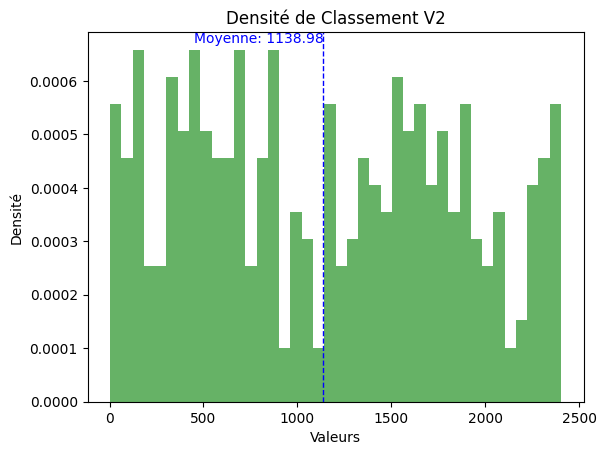


Sexe : Masculin



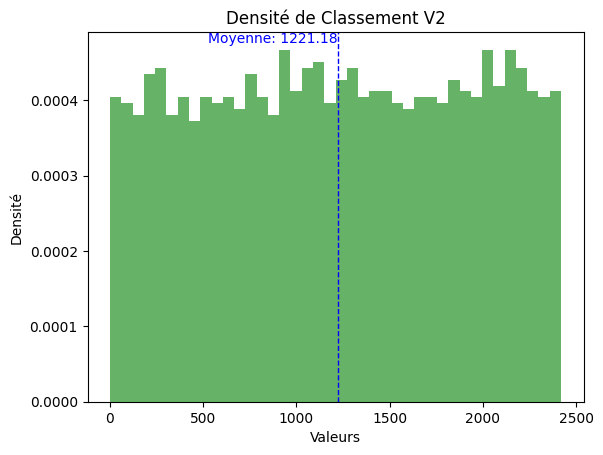

In [153]:
df_7415 = df.loc[(df['Groupe candidat - Code'] == 7415)]
graph("Classement V2", type_graph = 'densite', df = df_7415, en_fonction_de = ["Sexe", "Masculin", "Féminin"])

<p>On observe que les femmes sont en moyenne mieux classées que les hommes (moyenne de position plus basse).</br>
Cela permet de démonter une <strong>hypothèse</strong> que l'on avait qui était que les femmes étaient désavantagées dans les matières importantes pour la formation, à cause d'un biais de la société, mais l'effet observé est étonamment l'inverse.</br>
Si cela avait été le cas nous aurions pû mettre en place une règle dans le classement de <strong>discrimination positive</strong> où les femmes auraient eu un boost sur leurs points. Mais nous n'avons donc pas besoin.</p>

Candidat boursier - Libellé
Non boursier                            203
Boursier de l'enseignement scolaire      64
Boursier de l'enseignement supérieur     33


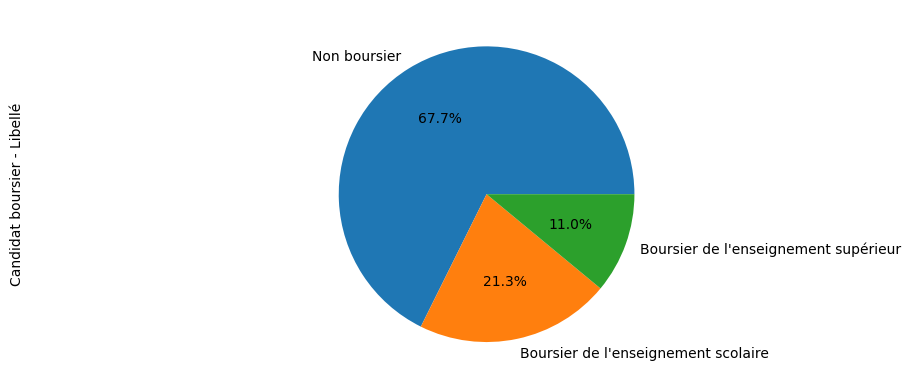

Candidat boursier - Libellé
Non boursier                            114
Boursier de l'enseignement scolaire      66
Boursier de l'enseignement supérieur     21


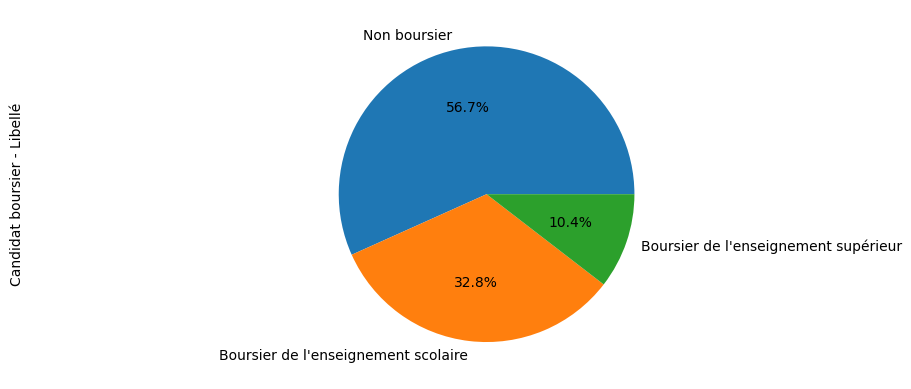

In [147]:
if(graph("Candidat boursier - Libellé",classement=classement(1,300,df_7415),type_graph="circulaire",minimum=0)): show()
if(graph("Candidat boursier - Libellé",classement=classement(-300,-100,df_7415),type_graph="circulaire",minimum=0)): show()


<p>Il est notable que le pourcentage d'étudiants bénéficiaires de bourses soit 10 % plus élevé parmi ceux figurant en bas du classement. Cette observation suggère peut-être la nécessité d'envisager des mesures de discrimination positive en faveur des candidats bénéficiaires de bourses. Pour confirmer cette hypothèse, examinons un autre graphique :</p>


Candidat boursier - Libellé : Boursier de l'enseignement supérieur



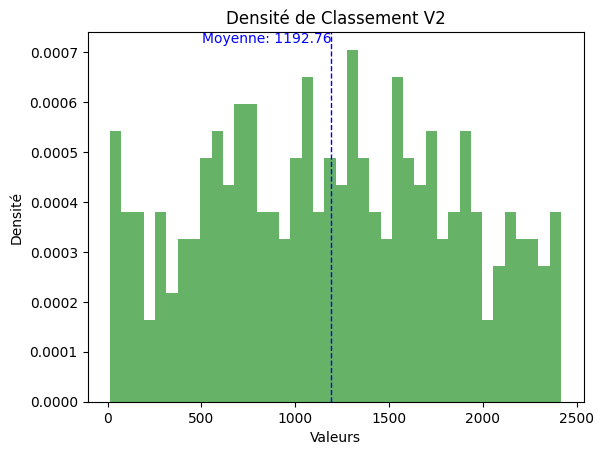


Candidat boursier - Libellé : Boursier de l'enseignement scolaire



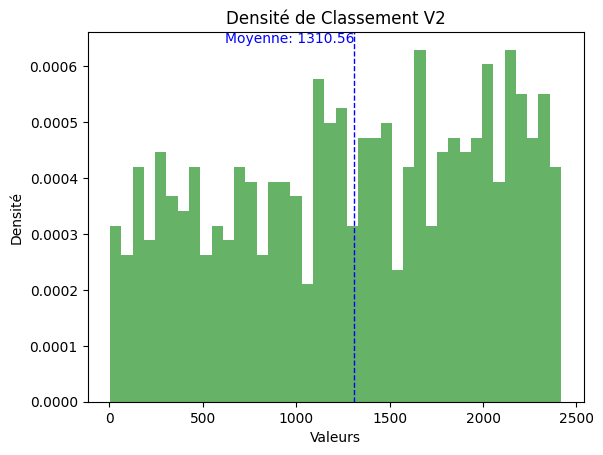


Candidat boursier - Libellé : Non boursier



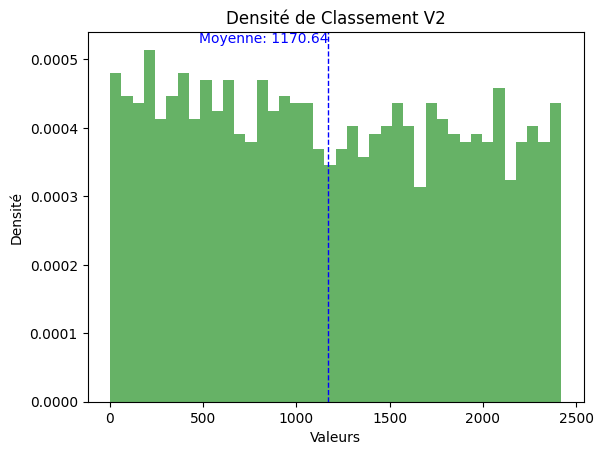

In [156]:
graph("Classement V2", type_graph = 'densite', df = df_7415, en_fonction_de = ["Candidat boursier - Libellé", "Non boursier", "Boursier de l'enseignement scolaire", "Boursier de l'enseignement supérieur"])


<p>Nous constatons un <strong>écart de 240 places</strong> sur 2400, ce qui représente <strong>10 %</strong> entre les candidats non boursiers et boursiers de l'enseignement scolaire.</p>
<p>Nous pourrions supposer que l'environnement dans lequel vivent les candidats boursiers est moins favorable à la performance scolaire que celui des candidats non boursiers.</br>
Si cette hypothèse est considérée comme pertinente, nous pourrions envisager d'ajouter environ 5 % au score des élèves boursiers afin de compenser cet effet. <em>(Il conviendrait de déterminer une valeur permettant d'aligner les deux groupes sans les confondre, sachant que la différence de notes pourrait simplement être une coïncidence.)</em></p>

Option facultative 1 Scolarité - Libellé 2022/2023
nan                                                         3425
Mathématiques Expertes                                       437
Mathématiques Complémentaires                                114
Education Physique et Sportive (facultatif)                   61
Langues et cultures de l'antiquité : Latin                    27
                                                            ... 
Droits et Grands Enjeux du monde Contemporain facultatif      10
Histoire des arts                                              7
Musique                                                        6
Langues et cultures de l'antiquité : Grec                      4
Danse                                                          1


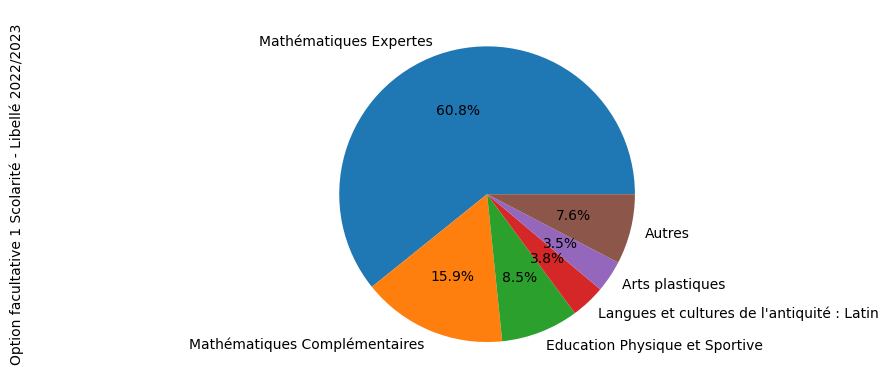

In [149]:
if(graph("Option facultative 1 Scolarité - Libellé 2022/2023",type_graph="circulaire")):show()

Option facultative 1 Scolarité - Libellé 2022/2023
nan                                            145
Mathématiques Expertes                         142
Education Physique et Sportive (facultatif)      4
Langues et cultures de l'antiquité : Latin       3
Arts plastiques                                  2
Langues et cultures de l'antiquité : Grec        1
Musique                                          1
Mathématiques Complémentaires                    1
Cinéma-Audiovisuel                               1


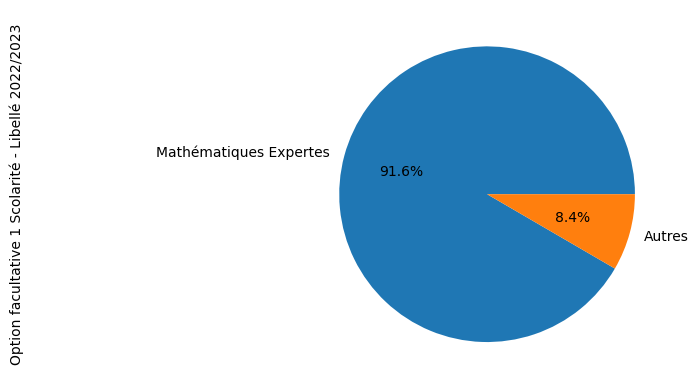

In [150]:
if(graph("Option facultative 1 Scolarité - Libellé 2022/2023",classement=classement(1,300,df_7415),type_graph="circulaire")):show()

<p>91.6 % des étudiants qui ont une option parmi les 300 premiers du classement ont mathématiques expertes, ce qui est beaucoup moins varié que dans le total</p> 